In [1]:
%pip install optuna edge-ml tsflex plotly tsfresh torch timeout_decorator

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pickle
import pandas as pd
project=pickle.load(open("data_snapshot/project_css25.pkl","rb"))

In [ ]:
sensor="deviceorientation"

In [3]:
df=pd.concat([d.data.iloc[40:-40].dropna().assign(**d.metaData) for d  in project.datasets if (d.name == sensor and d.data.shape[0]>0) and d.timeSeries[0].end-d.timeSeries[0].start>10000] )
df.set_index(["participantId","time"], inplace=True)
df=df[df.activity!="testing"]

In [4]:
ts_cols=[col for col in df.columns if col not in ["activity","mobile","browser"] ]
ts_cols

['alpha', 'beta', 'gamma']

In [5]:
from tsflex.features import FeatureCollection, FuncWrapper, MultipleFeatureDescriptors
from tsflex.processing import SeriesProcessor
from tsflex.features.integrations import tsfresh_settings_wrapper
from tsfresh.feature_extraction import MinimalFCParameters

import numpy as np

 

# Common statistical + signal features approximating TSFRESH minimal set
tsfresh_minimal_funcs =   [
        FuncWrapper(np.sum, output_names="sum"),
        FuncWrapper(np.median, output_names="median"),
        FuncWrapper(np.mean, output_names="mean"),
        FuncWrapper(lambda x: len(x), output_names="length"),
        FuncWrapper(np.std, output_names="std_dev"),
        FuncWrapper(np.var, output_names="var"),
        FuncWrapper(lambda x: np.sqrt(np.mean(np.square(x))), output_names="root_mean_square"),
        FuncWrapper(lambda x: np.max(x) if len(x) > 0 else np.nan, output_names="max"),
        FuncWrapper(lambda x: np.max(np.abs(x)) if len(x) > 0 else np.nan, output_names="abs_max"),
        FuncWrapper(lambda x: np.min(x) if len(x) > 0 else np.nan, output_names="min"),
    ]
#tsfresh_minimal_funcs=tsfresh_settings_wrapper(MinimalFCParameters())


fc = FeatureCollection( feature_descriptors = [ MultipleFeatureDescriptors(  
        series_names=ts_cols , 
        functions=tsfresh_minimal_funcs,
        windows=["1s"],
        strides=["1000ms"]
        )
        ] )


In [6]:
%env PYTHONWARNINGS=ignore

import warnings

from joblib import Parallel, delayed
from tqdm.notebook import tqdm




# Prepare the groups
grouped = df.reset_index().set_index("time").groupby(["participantId", "activity"])

# Optional: Convert to a list to avoid multiple iterations over the generator
grouped_items = list(grouped)

# Define your processing function
def process_group(pid, group):
    warnings.filterwarnings('ignore')
    feats=pd.concat(fc.calculate(group, n_jobs=1),axis=1)
    #display(feats)
    feats["participantId"]=pid[0]
    feats["activity"] = pid[1]
    return feats.dropna().reset_index().set_index(["participantId","time"])

# Wrap with tqdm for progress
results = Parallel(n_jobs=-1)(
    delayed(process_group)(pid, group)
    for pid, group in tqdm(grouped_items, desc="Processing groups")
)


df1=pd.concat(results, axis=0)
 #   display(all_feats)

df1

env: PYTHONWARNINGS=ignore


Processing groups:   0%|          | 0/24 [00:00<?, ?it/s]

alpha__sum__w=1s  alpha__median__w=1s  \
participantId time                                                             
10d83         2025-06-03 12:01:24.781       2515.500000            83.850006   
              2025-06-03 12:01:25.781       3036.300049            84.099998   
              2025-06-03 12:01:26.781       2552.300049            85.099998   
              2025-06-03 12:01:27.781       1947.899902            84.699997   
              2025-06-03 12:01:28.781       1778.200195            84.699997   
...                                                 ...                  ...   
1f683         2025-06-23 19:10:25.060        973.820007            16.240000   
              2025-06-23 19:10:26.060        972.840027            16.270000   
              2025-06-23 19:10:27.060        977.849976            16.309999   
              2025-06-23 19:10:28.060        979.290100            16.370001   
              2025-06-23 19:10:29.060        834.509949            12.525000   

                                       alpha__mean__w=1s  alpha__length__w=1s  \
participantId time                                                              
10d83         2025-06-03 12:01:24.781          83.849998                   30   
              2025-06-03 12:01:25.781          84.341667                   36   
              2025-06-03 12:01:26.781          85.076668                   30   
              2025-06-03 12:01:27.781          84.691299                   23   
              2025-06-03 12:01:28.781          84.676201                   21   
...                                                  ...                  ...   
1f683         2025-06-23 19:10:25.060          16.230333                   60   
              2025-06-23 19:10:26.060          16.214001                   60   
              2025-06-23 19:10:27.060          16.297499                   60   
              2025-06-23 19:10:28.060          16.321501                   60   
              2025-06-23 19:10:29.060          13.908499                   60   

                                       alpha__std_dev__w=1s  alpha__var__w=1s  \
participantId time                                                              
10d83         2025-06-03 12:01:24.781              0.117615          0.013833   
              2025-06-03 12:01:25.781              0.519816          0.270209   
              2025-06-03 12:01:26.781              0.192671          0.037122   
              2025-06-03 12:01:27.781              0.128243          0.016446   
              2025-06-03 12:01:28.781              0.106481          0.011338   
...                                                     ...               ...   
1f683         2025-06-23 19:10:25.060              0.036922          0.001363   
              2025-06-23 19:10:26.060              0.160958          0.025907   
              2025-06-23 19:10:27.060              0.054517          0.002972   
              2025-06-23 19:10:28.060              0.127434          0.016239   
              2025-06-23 19:10:29.060              2.439942          5.953319   

                                       alpha__root_mean_square__w=1s  \
participantId time                                                     
10d83         2025-06-03 12:01:24.781                      83.850075   
              2025-06-03 12:01:25.781                      84.343269   
              2025-06-03 12:01:26.781                      85.076889   
              2025-06-03 12:01:27.781                      84.691399   
              2025-06-03 12:01:28.781                      84.676262   
...                                                              ...   
1f683         2025-06-23 19:10:25.060                      16.230375   
              2025-06-23 19:10:26.060                      16.214800   
              2025-06-23 19:10:27.060                      16.297590   
              2025-06-23 19:10:28.060                      16.321999   
              2025-06-23 1

In [7]:
tsfresh_minimal_funcs

[FuncWrapper(sum, ['sum'], {}),
 FuncWrapper(median, ['median'], {}),
 FuncWrapper(mean, ['mean'], {}),
 FuncWrapper(<lambda>, ['length'], {}),
 FuncWrapper(std, ['std_dev'], {}),
 FuncWrapper(var, ['var'], {}),
 FuncWrapper(<lambda>, ['root_mean_square'], {}),
 FuncWrapper(<lambda>, ['max'], {}),
 FuncWrapper(<lambda>, ['abs_max'], {}),
 FuncWrapper(<lambda>, ['min'], {})]

In [8]:
df1

alpha__sum__w=1s  alpha__median__w=1s  \
participantId time                                                             
10d83         2025-06-03 12:01:24.781       2515.500000            83.850006   
              2025-06-03 12:01:25.781       3036.300049            84.099998   
              2025-06-03 12:01:26.781       2552.300049            85.099998   
              2025-06-03 12:01:27.781       1947.899902            84.699997   
              2025-06-03 12:01:28.781       1778.200195            84.699997   
...                                                 ...                  ...   
1f683         2025-06-23 19:10:25.060        973.820007            16.240000   
              2025-06-23 19:10:26.060        972.840027            16.270000   
              2025-06-23 19:10:27.060        977.849976            16.309999   
              2025-06-23 19:10:28.060        979.290100            16.370001   
              2025-06-23 19:10:29.060        834.509949            12.525000   

                                       alpha__mean__w=1s  alpha__length__w=1s  \
participantId time                                                              
10d83         2025-06-03 12:01:24.781          83.849998                   30   
              2025-06-03 12:01:25.781          84.341667                   36   
              2025-06-03 12:01:26.781          85.076668                   30   
              2025-06-03 12:01:27.781          84.691299                   23   
              2025-06-03 12:01:28.781          84.676201                   21   
...                                                  ...                  ...   
1f683         2025-06-23 19:10:25.060          16.230333                   60   
              2025-06-23 19:10:26.060          16.214001                   60   
              2025-06-23 19:10:27.060          16.297499                   60   
              2025-06-23 19:10:28.060          16.321501                   60   
              2025-06-23 19:10:29.060          13.908499                   60   

                                       alpha__std_dev__w=1s  alpha__var__w=1s  \
participantId time                                                              
10d83         2025-06-03 12:01:24.781              0.117615          0.013833   
              2025-06-03 12:01:25.781              0.519816          0.270209   
              2025-06-03 12:01:26.781              0.192671          0.037122   
              2025-06-03 12:01:27.781              0.128243          0.016446   
              2025-06-03 12:01:28.781              0.106481          0.011338   
...                                                     ...               ...   
1f683         2025-06-23 19:10:25.060              0.036922          0.001363   
              2025-06-23 19:10:26.060              0.160958          0.025907   
              2025-06-23 19:10:27.060              0.054517          0.002972   
              2025-06-23 19:10:28.060              0.127434          0.016239   
              2025-06-23 19:10:29.060              2.439942          5.953319   

                                       alpha__root_mean_square__w=1s  \
participantId time                                                     
10d83         2025-06-03 12:01:24.781                      83.850075   
              2025-06-03 12:01:25.781                      84.343269   
              2025-06-03 12:01:26.781                      85.076889   
              2025-06-03 12:01:27.781                      84.691399   
              2025-06-03 12:01:28.781                      84.676262   
...                                                              ...   
1f683         2025-06-23 19:10:25.060                      16.230375   
              2025-06-23 19:10:26.060                      16.214800   
              2025-06-23 19:10:27.060                      16.297590   
              2025-06-23 19:10:28.060                      16.321999   
              2025-06-23 1

In [9]:
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)


for train_idx, test_idx in splitter.split(y=df1.activity, X=df1.drop(columns=["activity"]), groups=df1.reset_index().participantId):
    train, test = df1.iloc[train_idx], df1.iloc[test_idx]

In [10]:
test.reset_index().participantId.unique()

array(['10d83', '11416'], dtype=object)

In [11]:
train.reset_index().participantId.unique()

array(['12358', '12f77', '150c9', '152a7', '15b85', '18582', '191d4',
       '19ee7', '1a045', '1b682', '1b728', '1b949', '1dd54', '1e570',
       '1f683'], dtype=object)

In [12]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [13]:
train.activity.factorize()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [14]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
import optuna

X,y,groups= train.drop(columns=["activity"]), train.activity, train.reset_index().participantId

cv = GroupKFold(n_splits=5)


def objective(trial):
    clf=Pipeline([ ("sample", SMOTE()) , ("clf",DecisionTreeClassifier(max_depth=trial.suggest_int('max_depth',1,20))),])
    return cross_val_score(clf,X,y,cv=cv, groups=groups, scoring="f1_macro").mean()

study= optuna.study.create_study(sampler= optuna.samplers.GPSampler(), direction="maximize")
study.optimize(objective,n_trials=1)

/tmp/ipykernel_6814/3960902939.py:16: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study= optuna.study.create_study(sampler= optuna.samplers.GPSampler(), direction="maximize")
[I 2025-07-12 21:32:57,942] A new study created in memory with name: no-name-e430dd37-d7fc-4a67-b737-50ced9049c17
[I 2025-07-12 21:32:58,311] Trial 0 finished with value: 0.5820993589778228 and parameters: {'max_depth': 16}. Best is trial 0 with value: 0.5820993589778228.


In [63]:
cv = GroupKFold(n_splits=5)
splits=list(cv.split(X, y, groups))
splits[0]

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
        186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
        199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
        212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
        225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
        238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
        251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
        264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276,
        277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289,
        290, 291, 292, 293, 294, 295, 296, 297, 298

In [68]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier, Perceptron
)
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.utils import all_estimators
import timeout_decorator
import random

X,y,groups= train.drop(columns=["activity"]), train.activity, train.reset_index().participantId
cv = GroupKFold(n_splits=5)
splits=list(cv.split(X, y, groups))



#@timeout_decorator.timeout(30, timeout_exception=optuna.TrialPruned, use_signals=True)
def cross_val_score_to(clf,X,y,cv=None, groups=None, scoring=None):
    cross_val_score(clf,X,y,cv=cv, groups=groups, scoring=scoring)

clfs={
        "lr": LogisticRegression,
        "ridge": RidgeClassifier,
        "sgd": SGDClassifier,
        "lsvc": LinearSVC,
        "svc": SVC,
        "pac": PassiveAggressiveClassifier,
        "perc": Perceptron,
        "dt": DecisionTreeClassifier,
        "et": ExtraTreeClassifier,
        "rf":RandomForestClassifier,
        "etrees":ExtraTreesClassifier,
     }

def objective(trial):
    from sklearn.datasets import load_iris  # replace with your data

    model_name = trial.suggest_categorical("classifier", clfs.keys())

    if model_name == "lr":
        clf = LogisticRegression(
            C=trial.suggest_float("lr_C", 1e-3, 100, log=True),
            solver="liblinear"
        )
    elif model_name == "ridge":
        clf = RidgeClassifier(
            alpha=trial.suggest_float("ridge_alpha", 1e-3, 10, log=True)
        )
    elif model_name == "sgd":
        clf = SGDClassifier(
            loss=trial.suggest_categorical("sgd_loss", ["hinge", "log_loss"]),
            alpha=trial.suggest_float("sgd_alpha", 1e-5, 1e-1, log=True),
            max_iter=1000,
            tol=1e-3
        )
    elif model_name == "lsvc":
        clf = LinearSVC(
            C=trial.suggest_float("lsvc_C", 1e-3, 100, log=True),
            max_iter=1000
        )
    elif model_name == "svc":
        clf = SVC(
            C=trial.suggest_float("svc_C", 1e-3, 100, log=True),
            kernel=trial.suggest_categorical("svc_kernel", ["linear", "rbf"]),
            gamma=trial.suggest_categorical("svc_gamma", ["scale", "auto"])
        )
    elif model_name == "pac":
        clf = PassiveAggressiveClassifier(
            C=trial.suggest_float("pac_C", 1e-3, 10, log=True)
        )
    elif model_name == "perc":
        clf = Perceptron(
            alpha=trial.suggest_float("perc_alpha", 1e-5, 1e-1, log=True),
            max_iter=1000
        )
    elif model_name == "dt":
        clf = DecisionTreeClassifier(
            max_depth=trial.suggest_int("dt_max_depth", 2, 20),
            min_samples_split=trial.suggest_int("dt_min_samples_split", 2, 10)
        )
    elif model_name == "et":
        clf = ExtraTreeClassifier(
            max_depth=trial.suggest_int("et_max_depth", 2, 20),
            min_samples_split=trial.suggest_int("et_min_samples_split", 2, 10)
        )
    elif model_name == "rf":
        clf = RandomForestClassifier(
            n_estimators=trial.suggest_int("rf_n_estimators", 50, 200),
            max_depth=trial.suggest_int("rf_max_depth", 2, 20),
            min_samples_split=trial.suggest_int("rf_min_samples_split", 2, 10)
        )
    elif model_name == "etrees":
        clf = ExtraTreesClassifier(
            n_estimators=trial.suggest_int("etrees_n_estimators", 50, 200),
            max_depth=trial.suggest_int("etrees_max_depth", 2, 20),
            min_samples_split=trial.suggest_int("etrees_min_samples_split", 2, 10)
        )
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # Pipeline with scaling (important for linear models and SVMs)
    pipeline = make_pipeline(RobustScaler(), clf)
    #return cross_val_score(clf,X,y,cv=cv, groups=groups, scoring="f1_macro").mean()
    train_idx, test_idx = random.choice(splits)
    pipeline.fit(X.iloc[train_idx], y.iloc[train_idx])

    # Predict and evaluate
    y_pred = pipeline.predict(X.iloc[test_idx])
    return f1_score(y.iloc[test_idx], y_pred, average='macro')

study= optuna.study.create_study(sampler= optuna.samplers.GPSampler(), direction="maximize")
study.optimize(objective,n_trials=100,n_jobs=-1, timeout=60, show_progress_bar=True)

/tmp/ipykernel_6814/2964493964.py:116: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study= optuna.study.create_study(sampler= optuna.samplers.GPSampler(), direction="maximize")
[I 2025-07-12 22:27:21,231] A new study created in memory with name: no-name-d68a36e0-f80b-442b-9dc4-b3e05f0735eb


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-12 22:27:21,536] Trial 0 finished with value: 0.3520647083865474 and parameters: {'classifier': 'pac', 'pac_C': 0.00554046947295823}. Best is trial 0 with value: 0.3520647083865474.
[I 2025-07-12 22:27:21,723] Trial 7 finished with value: 0.3414428646656135 and parameters: {'classifier': 'pac', 'pac_C': 0.5979225237410112}. Best is trial 0 with value: 0.3520647083865474.
[I 2025-07-12 22:27:21,727] Trial 2 finished with value: 0.3177447981571693 and parameters: {'classifier': 'perc', 'perc_alpha': 0.06892628344471788}. Best is trial 0 with value: 0.3520647083865474.
[I 2025-07-12 22:27:21,740] Trial 6 finished with value: 0.40221323685890614 and parameters: {'classifier': 'et', 'et_max_depth': 5, 'et_min_samples_split': 6}. Best is trial 6 with value: 0.40221323685890614.
[I 2025-07-12 22:27:21,749] Trial 3 finished with value: 0.32511522016769395 and parameters: {'classifier': 'svc', 'svc_C': 46.778759493056604, 'svc_kernel': 'rbf', 'svc_gamma': 'auto'}. Best is trial 6 wit

In [69]:
study.best_params

{'classifier': 'etrees',
 'etrees_n_estimators': 176,
 'etrees_max_depth': 19,
 'etrees_min_samples_split': 10}

In [70]:
params={k.removeprefix(study.best_params["classifier"]+"_"): v for k, v in study.best_params.items()}
params.pop("classifier", None) 
clf=clfs[study.best_params['classifier']](**params)
clf

ExtraTreesClassifier(max_depth=19, min_samples_split=10, n_estimators=176)

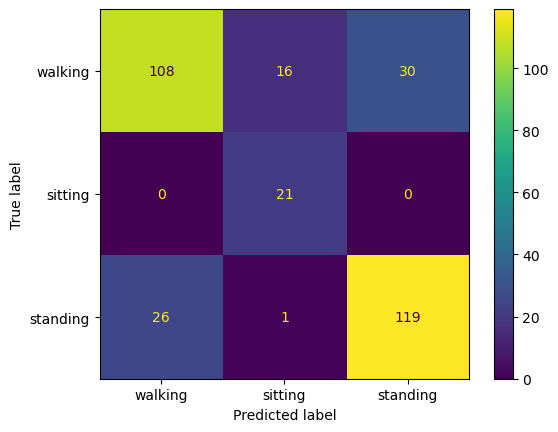

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
scaler=RobustScaler()
pipeline = make_pipeline(scaler, clf)
pipeline.fit(train.drop(columns=["activity"]),train.activity)
cm = confusion_matrix(test.activity, pipeline.predict(test.drop(columns=["activity"])))
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=train.activity.unique()).plot()

In [72]:
from sklearn import tree

if( isinstance(clf,DecisionTreeClassifier) ): 
    tree.plot_tree(clf)

In [52]:
%pip install m2cgen

Note: you may need to restart the kernel to use updated packages.


In [74]:
import m2cgen as m2c
code = m2c.export_to_javascript(clf)


In [54]:
clf.feature_names_in_

AttributeError: 'DecisionTreeClassifier' object has no attribute 'feature_names_in_'

In [109]:
import json
scaler_str=json.dumps(
    {
        "scale": list(scaler.scale_),
        "center": list(scaler.center_),
        "name": type(scaler).__name__
    })
print(scaler_str)

{"scale": [15712.007080078125, 333.96999526023865, 325.495840549469, 18.0, 6.090828824788332, 38.02796925837174, 326.204327583313, 343.15000677108765, 343.15000677108765, 323.9149887561798, 824.6800193786621, 13.893750429153442, 13.20384418964386, 18.0, 2.848453914746642, 8.581927417893894, 12.534270524978638, 14.057499647140503, 14.329999923706055, 16.414999783039093, 353.41001892089844, 8.176249980926514, 8.283334016799927, 18.0, 2.6658576261252165, 7.631589200813323, 7.092985272407532, 10.379999995231628, 9.549999713897705, 7.049999902024865], "center": [3549.9049072265625, 81.70000076293945, 89.27093124389648, 60.0, 0.7828531265258789, 0.6128600835800171, 92.0, 92.69999694824219, 92.69999694824219, 24.43000030517578, 613.6800231933594, 11.84749984741211, 11.865582942962646, 60.0, 0.3570331186056137, 0.12747357785701752, 13.591876983642578, 15.84000015258789, 16.8149995803833, 9.539999961853027, -26.27000331878662, -0.4399999976158142, -0.4425000697374344, 60.0, 0.4930809885263443, 

In [110]:
#
js=f"""{code}

const classifier =
{{ 
 inputs: {json.dumps(ts_cols)} ,
 classes: {json.dumps(list(clf.classes_))} ,
 window: {0-window_ms},
 score: score , 
 scale: {scaler_str}
}}
;

module.exports = classifier;"""

with open("data_snapshot/model.mjs", "w") as file:
    file.write(js)

In [103]:
window_ms=1000

In [105]:
clf.classes_

array(['sitting', 'standing', 'walking'], dtype=object)